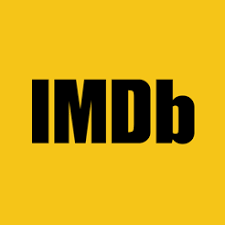</img>

#### IMDB sentiment analysis

 In this notebook im showing few methids to solve the IMDB sentiment analysis challenge.
 the methods are:
 * BiLSTMs + Attention (learned embeddings)
 * Pretrained embeddings
    * gnews-swivel-20dim-with-oov
    * gnews-swivel-20dim
    * nnlm-en-dim50
    * nnlm-en-dim128
    * universal-sentence-encoder
 * Fine tunning:
    * BERT
    * XLNet

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


###### Load the data

In [2]:
import os
import re
import nltk
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf

random.seed(42)
np.random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
tf.random.set_seed(42)

nltk.download('stopwords')
from nltk.corpus import stopwords
  




import tensorflow.keras as keras
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional

from keras import regularizers

tf.get_logger().setLevel('ERROR')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


In [3]:
!pip install transformers --quiet

     |████████████████████████████████| 778kB 4.7MB/s 
     |████████████████████████████████| 3.0MB 24.4MB/s 
     |████████████████████████████████| 890kB 42.6MB/s 
     |████████████████████████████████| 1.1MB 63.1MB/s 


In [4]:
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load('imdb_reviews', 
          split = (tfds.Split.TRAIN, tfds.Split.TEST),
          as_supervised=True,
          with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteHBRPOI/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteHBRPOI/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteHBRPOI/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
# Hyperparameters

MAX_FEATURES = 6000
EMBED_SIZE = 512
MAX_LEN = 400  # Since our mean length is ~ 230

BATCH_SIZE = 200
EPOCHS = 20
VALIDATION_SPLIT = 0.2

RNN_CELL_SIZE = 256
NUM_ATTENTION_HEADS = 8

DROPOUT_RATE = 0.5
REGULARIZERS_RATE = 0.005

###### Preprocessing the data

In [5]:
review_list = []
sentiment_list = []
for review, label in tfds.as_numpy(ds_train):
    review_list.append(tf.compat.as_str_any(review))
    sentiment_list.append(label)
print(len(review_list))
for review, label in tfds.as_numpy(ds_test):
    review_list.append(tf.compat.as_str_any(review))
    sentiment_list.append(label)
print(len(review_list))

25000
50000


In [6]:
df = pd.DataFrame({'review': review_list, 'sentiment': sentiment_list})

stop_words = set(stopwords.words("english"))

 
def clean_text(text):
	text = re.sub(r'[^\w\s]','',text, re.UNICODE)
	text = text.lower()
	# text = [word for word in text.split() if  word not in stop_words]
	# text = " ".join(text)
	return text
  
df['Processed_Reviews'] = df.review.apply(lambda x: clean_text(x))
df.head()

,review,sentiment,Processed_Reviews
0,This was an absolutely terrible movie. Don't b...,0,this was an absolutely terrible movie dont be ...
1,"I have been known to fall asleep during films,...",0,i have been known to fall asleep during films ...
2,Mann photographs the Alberta Rocky Mountains i...,0,mann photographs the alberta rocky mountains i...
3,This is the kind of film for a snowy Sunday af...,1,this is the kind of film for a snowy sunday af...
4,"As others have mentioned, all the women that g...",1,as others have mentioned all the women that go...


In [7]:
mean_word_len = df.Processed_Reviews.apply(lambda x: len(x.split(" "))).mean()
print(f"Dataset with shape of {df.shape[0]} samples. \nMean number of words is: {mean_word_len}. \nDistribution of lables is: \n{df.sentiment.value_counts()}")

Dataset with shape of 50000 samples. 
Mean number of words is: 231.14594. 
Distribution of lables is: 
1    25000
0    25000
Name: sentiment, dtype: int64


###### BiLSTMs + Attention (learned embeddings)

In [8]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(df['Processed_Reviews'])
list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_Reviews'])
  
X_train = pad_sequences(list_tokenized_train, maxlen=MAX_LEN, padding='post')
y_train = df['sentiment']

In [9]:
max([len(x) for x in list_tokenized_train])

2128

In [10]:
class Attention(tf.keras.Model):
	def __init__(self, units):
		super(Attention, self).__init__()
		self.W1 = tf.keras.layers.Dense(units)
		self.W2 = tf.keras.layers.Dense(units)
		self.V = tf.keras.layers.Dense(1)

	def call(self, features, hidden):
		# hidden shape == (batch_size, hidden size)
		# hidden_with_time_axis shape == (batch_size, 1, hidden size)
		# we are doing this to perform addition to calculate the score
		hidden_with_time_axis = tf.expand_dims(hidden, 1)
		  
		# score shape == (batch_size, max_length, 1)
		# we get 1 at the last axis because we are applying score to self.V
		# the shape of the tensor before applying self.V is (batch_size, max_length, units)
		score = tf.nn.tanh(
			self.W1(features) + self.W2(hidden_with_time_axis))
		# attention_weights shape == (batch_size, max_length, 1)
		attention_weights = tf.nn.softmax(self.V(score), axis=1)
		  
		# context_vector shape after sum == (batch_size, hidden_size)
		context_vector = attention_weights * features
		context_vector = tf.reduce_sum(context_vector, axis=1)
		return context_vector, attention_weights

In [11]:
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
context_vector, attention_weights = Attention(NUM_ATTENTION_HEADS)(lstm, state_h)
dense = Dense(512, activation="relu", 
              kernel_regularizer=regularizers.l2(REGULARIZERS_RATE))(context_vector)
dropout = Dropout(DROPOUT_RATE)(dense)
dense = Dense(256, activation="relu")(dropout)
dropout = Dropout(DROPOUT_RATE)(dense)
dense = Dense(128, activation="relu")(dropout)
dropout = Dropout(DROPOUT_RATE)(dense)
# dense = Dense(128, activation="relu")(dropout)
# dropout = Dropout(DROPOUT_RATE)(dense)
output = Dense(1, activation="sigmoid")(dropout)
  
model = keras.Model(inputs=sequence_input, outputs=output)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 400, 512)     3072000     input_1[0][0]                    
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 400, 512)     1574912     embedding[0][0]                  
__________________________________________________________________________________________________
bi_lstm_1 (Bidirectional)       [(None, 400, 512), ( 1574912     bi_lstm_0[0][0]                  
______________________________________________________________________________________________

In [13]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+tf.keras.backend.epsilon())
    return f1_val

In [14]:
METRICS = [
	keras.metrics.BinaryAccuracy(name='accuracy'),
  f1_score
]

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='min', baseline=None, restore_best_weights=False)
]

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=METRICS)

In [ ]:
history = model.fit(X_train,y_train,
					verbose=1,
					epochs=EPOCHS,
					batch_size=BATCH_SIZE,
					callbacks=my_callbacks,
					validation_split=VALIDATION_SPLIT)

Epoch 1/20
200/200 [==============================] - 105s 525ms/step - loss: 0.6942 - accuracy: 0.8094 - f1_score: 0.8033 - val_loss: 0.2776 - val_accuracy: 0.8869 - val_f1_score: 0.8925
Epoch 2/20
200/200 [==============================] - 103s 516ms/step - loss: 0.2427 - accuracy: 0.9103 - f1_score: 0.9100 - val_loss: 0.2584 - val_accuracy: 0.8978 - val_f1_score: 0.8949
Epoch 3/20
200/200 [==============================] - 103s 515ms/step - loss: 0.1981 - accuracy: 0.9297 - f1_score: 0.9294 - val_loss: 0.2440 - val_accuracy: 0.9049 - val_f1_score: 0.9063
Epoch 4/20
200/200 [==============================] - 103s 515ms/step - loss: 0.1530 - accuracy: 0.9481 - f1_score: 0.9477 - val_loss: 0.2634 - val_accuracy: 0.8985 - val_f1_score: 0.8972
Epoch 5/20
200/200 [==============================] - 103s 517ms/step - loss: 0.1237 - accuracy: 0.9596 - f1_score: 0.9593 - val_loss: 0.2910 - val_accuracy: 0.8982 - val_f1_score: 0.8973


In [ ]:
model.predict(np.array([X_train[4]]))

array([[0.9816851]], dtype=float32)

###### Pretrained embeddings

In [ ]:
!pip install tensorflow-hub
import tensorflow_hub as hub

print("Hub version: ", hub.__version__)

Hub version:  0.8.0


In [ ]:
models = ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1",
          "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1",
          "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
          "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1",
          "https://tfhub.dev/google/universal-sentence-encoder/4",
          # "https://tfhub.dev/google/elmo/3",
          # "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
          ]

batch_size = 512
METRICS = [
	keras.metrics.BinaryAccuracy(name='accuracy')
]

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='min', baseline=None, restore_best_weights=False)
]

for model_name in models:
  print(f"Model name: {model_name}")
  print(f"Batch size: {batch_size}")
  hub_layer = hub.KerasLayer(model_name, input_shape=[], 
                            dtype=tf.string, trainable=True)
  FF_SIZE = hub_layer(df.Processed_Reviews.iloc[:1]).shape[1]
  print(f"Feedforward units: {FF_SIZE}")
  print("-"*4)
  model = tf.keras.Sequential()
  model.add(hub_layer)
  model.add(tf.keras.layers.Dense(FF_SIZE, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=METRICS)

  history = model.fit(df.Processed_Reviews.values, df.sentiment.values,
                      verbose=1,
                      epochs=EPOCHS,
                      batch_size=batch_size,
                      callbacks=my_callbacks,
                      validation_split=VALIDATION_SPLIT)
  
  print("-"*4)

Model name: https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1
Batch size: 512
Feedforward units: 20
----
Epoch 1/20
79/79 [==============================] - 3s 35ms/step - loss: 7.6354 - accuracy: 0.4992 - val_loss: 7.5760 - val_accuracy: 0.5031
Epoch 2/20
79/79 [==============================] - 3s 34ms/step - loss: 7.6353 - accuracy: 0.4993 - val_loss: 7.5774 - val_accuracy: 0.5031
Epoch 3/20
79/79 [==============================] - 3s 34ms/step - loss: 7.6353 - accuracy: 0.4993 - val_loss: 7.5760 - val_accuracy: 0.5031
Epoch 4/20
79/79 [==============================] - 3s 34ms/step - loss: 7.6353 - accuracy: 0.4993 - val_loss: 7.5774 - val_accuracy: 0.5030
Epoch 5/20
79/79 [==============================] - 3s 34ms/step - loss: 7.6353 - accuracy: 0.4993 - val_loss: 7.5774 - val_accuracy: 0.5030
----
Model name: https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1
Batch size: 512
Feedforward units: 20
----
Epoch 1/20
79/79 [==============================] - 3s 

###### Fine tunning BERT

In [ ]:
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
max_length = 512
batch_size = 6

In [ ]:
def convert_example_to_feature(review):
  
  # combine step for tokenization, WordPiece vector mapping, adding special tokens as well as truncating reviews longer than the max length
  
  return tokenizer.encode_plus(review, 
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
                truncation=True
              )
# map to the expected input to TFBertForSequenceClassification, see here 
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

def encode_examples(ds, limit=-1):

  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []

  if (limit > 0):
      ds = ds.take(limit)
    
  for review, label in tqdm(tfds.as_numpy(ds)):

    bert_input = convert_example_to_feature(review.decode())
  
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [ ]:
# train dataset
ds_train_encoded = encode_examples(ds_train).shuffle(10000).batch(batch_size)

# test dataset
ds_test_encoded = encode_examples(ds_test).batch(batch_size)

# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5

# we will do just 1 epoch for illustration, though multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 10

25000it [01:35, 262.96it/s]
25000it [01:33, 266.13it/s]


In [ ]:
# model initialization
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

my_callbacks = [
                tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='min', baseline=None, restore_best_weights=True)
]
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
bert_history = model.fit(ds_train_encoded, 
                         epochs=number_of_epochs, 
                         validation_data=ds_test_encoded, 
                         callbacks=my_callbacks)

Epoch 1/10
4167/4167 [==============================] - 2454s 589ms/step - loss: 0.2401 - accuracy: 0.9032 - val_loss: 0.1958 - val_accuracy: 0.9242
Epoch 2/10
4167/4167 [==============================] - 2456s 589ms/step - loss: 0.1249 - accuracy: 0.9576 - val_loss: 0.1725 - val_accuracy: 0.9346
Epoch 3/10
4167/4167 [==============================] - 2451s 588ms/step - loss: 0.0696 - accuracy: 0.9772 - val_loss: 0.2456 - val_accuracy: 0.9198
Epoch 4/10
4167/4167 [==============================] - 2453s 589ms/step - loss: 0.0451 - accuracy: 0.9861 - val_loss: 0.2513 - val_accuracy: 0.9263


In [ ]:
model.save_pretrained('/content/drive/My Drive/projects/IMDB sentiment analysis Bi-LSTM + Attention/bert_model')

In [ ]:
tokenizer.save_pretrained('/content/drive/My Drive/projects/IMDB sentiment analysis Bi-LSTM + Attention/bert_model')

('/content/drive/My Drive/projects/IMDB sentiment analysis Bi-LSTM + Attention/bert_model/vocab.txt',
 '/content/drive/My Drive/projects/IMDB sentiment analysis Bi-LSTM + Attention/bert_model/special_tokens_map.json',
 '/content/drive/My Drive/projects/IMDB sentiment analysis Bi-LSTM + Attention/bert_model/added_tokens.json')

Load BERT model and evaluate

In [ ]:
new_model = TFBertForSequenceClassification.from_pretrained('/content/drive/My Drive/projects/IMDB sentiment analysis Bi-LSTM + Attention/bert_model')
new_tokenizer = BertTokenizer.from_pretrained('/content/drive/My Drive/projects/IMDB sentiment analysis Bi-LSTM + Attention/bert_model')


If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
new_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
new_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

new_model.evaluate(ds_test_encoded)

4167/4167 [==============================] - 636s 153ms/step - loss: 0.1725 - accuracy: 0.9346


[0.17245008051395416, 0.9346399903297424]

###### Fine tunning XLNet


In [5]:
from transformers import TFXLNetModel, TFXLNetForSequenceClassification, XLNetTokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [6]:
max_length = 512
batch_size = 8

In [7]:
def convert_example_to_feature(review):
  
  # combine step for tokenization, WordPiece vector mapping, adding special tokens as well as truncating reviews longer than the max length
  
  return tokenizer.encode_plus(review, 
                # add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                # return_attention_mask = True, # add attention mask to not focus on pad tokens
                truncation=True
              )
  
  # map to the expected input to TFBertForSequenceClassification, see here 
def map_example_to_dict(input_ids, attention_masks, label):
  return {
      "input_ids": input_ids,
      "attention_mask": attention_masks,
  }, label

def encode_examples(ds, limit=-1):

  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  attention_mask_list = []
  label_list = []

  if (limit > 0):
      ds = ds.take(limit)
    
  for review, label in tqdm(tfds.as_numpy(ds)):

    bert_input = convert_example_to_feature(review.decode())
  
    input_ids_list.append(bert_input['input_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, label_list)).map(map_example_to_dict)

In [8]:
# train dataset
ds_train_encoded = encode_examples(ds_train).shuffle(10000).batch(batch_size)

# test dataset
ds_test_encoded = encode_examples(ds_test).batch(batch_size)

# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5

# we will do just 1 epoch for illustration, though multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 4

25000it [00:50, 497.25it/s]
25000it [00:49, 500.17it/s]


In [9]:
# model initialization
model = TFXLNetForSequenceClassification.from_pretrained('xlnet-base-cased')

# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
my_callbacks = [
                tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=0, mode='min', baseline=None, restore_best_weights=True)
]

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
model.summary()

Model: "tfxl_net_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFXLNetMainLaye multiple                  116718336 
_________________________________________________________________
sequence_summary (TFSequence multiple                  590592    
_________________________________________________________________
logits_proj (Dense)          multiple                  1538      
Total params: 117,310,466
Trainable params: 117,310,466
Non-trainable params: 0
_________________________________________________________________


In [11]:
xlnet_history = model.fit(ds_train_encoded, 
                          epochs=number_of_epochs, 
                          validation_data=ds_test_encoded,
                          callbacks=my_callbacks)

Epoch 1/4
3125/3125 [==============================] - 4514s 1s/step - loss: 0.2047 - accuracy: 0.9214 - val_loss: 0.1628 - val_accuracy: 0.9438
Epoch 2/4
3125/3125 [==============================] - 4524s 1s/step - loss: 0.1236 - accuracy: 0.9559 - val_loss: 0.1590 - val_accuracy: 0.9439
Epoch 3/4
3125/3125 [==============================] - 4527s 1s/step - loss: 0.0769 - accuracy: 0.9747 - val_loss: 0.2000 - val_accuracy: 0.9409


In [12]:
model.save_pretrained('/content/drive/My Drive/projects/IMDB sentiment analysis Bi-LSTM + Attention/xlnet_model')
tokenizer.save_pretrained('/content/drive/My Drive/projects/IMDB sentiment analysis Bi-LSTM + Attention/xlnet_model')

('/content/drive/My Drive/projects/IMDB sentiment analysis Bi-LSTM + Attention/xlnet_model/spiece.model',
 '/content/drive/My Drive/projects/IMDB sentiment analysis Bi-LSTM + Attention/xlnet_model/special_tokens_map.json',
 '/content/drive/My Drive/projects/IMDB sentiment analysis Bi-LSTM + Attention/xlnet_model/added_tokens.json')

Load XLNet model and evaluate

In [9]:
new_model = TFXLNetForSequenceClassification.from_pretrained('/content/drive/My Drive/projects/IMDB sentiment analysis Bi-LSTM + Attention/xlnet_model')
new_tokenizer = XLNetTokenizer.from_pretrained('/content/drive/My Drive/projects/IMDB sentiment analysis Bi-LSTM + Attention/xlnet_model')


If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFXLNetForSequenceClassification for predictions without further training.


In [10]:
new_model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
new_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

new_model.evaluate(ds_test_encoded)

Model: "tfxl_net_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFXLNetMainLaye multiple                  116718336 
_________________________________________________________________
sequence_summary (TFSequence multiple                  590592    
_________________________________________________________________
logits_proj (Dense)          multiple                  1538      
Total params: 117,310,466
Trainable params: 117,310,466
Non-trainable params: 0
_________________________________________________________________
3125/3125 [==============================] - 973s 311ms/step - loss: 0.1590 - accuracy: 0.9439


[0.15900878608226776, 0.9439200162887573]